# Projection on vertical modes

This notebook contains instruction for computing mean strat and corresponding vertical modes, and then project fields onto this basis. It is written to deal with cos/sin harmonics fields but the method is general.

N.B.: in this case, linear EOS with Tcoef=1, hence $\rho=T$

In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
import xarray as xr

import crocosi.postp as pp
import crocosi.gridop as gop
import crocosi.vmodes as vmd
import sys
sys.path.append('./dev')
import cswbib as bib # a few useful functions that should probably be in gridop or Vmodes

/home1/datahome/nlahaye/miniconda3/envs/croco/lib/python3.7/site-packages/distributed/utils.py:133: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
### this is not mandatory: dask cluster

from dask.distributed import Client, LocalCluster
cluster = LocalCluster() # dashboard_address=':8787'
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:50281 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 17.18 GB


# Read netcdf files
loading simulation using postp Run class

In [119]:
root_path = '/home/datawork-lops-osi/equinox/jetn/'
run = 'jet_cfg1_wp75_4km_1500a2000j_floats_lev50_itide/'
it = 1 # time index (working with one time index for this example)

r = pp.Run(root_path+run, prefix='file_',open_nc=['grid','his'], verbose=True)
ds = r['his'].isel(time=it)

### N.B.: Here we should specify wether some dimensions are periodic (e.g. x)

Analysing directory /home/datawork-lops-osi/equinox/jetn/jet_cfg1_wp75_4km_1500a2000j_floats_lev50_itide/
Found 5 segments
Found 25 his files
Found 5 grid files
Detected time step of 300.0 s
Detected theta_s = 5.0
Detected theta_b = 0.0
Detected Hc = 100.0 m
Detected rho0 = 1000.0 kg/m^3
Detected H = 4000.0 m
Found 9 columns in output.mpi:
['STEP', 'time[DAYS]', 'KINETIC_ENRG', 'POTEN_ENRG', 'TOTAL_ENRG', 'NET_VOLUME', 'trd', 'ENSTROPHY', 'BTKIN_ENRG']
Opening NC datasets:  ['his', 'grid']
Grid size: (L ,M, N) = (258, 722, 50)


# Compute mean stratification

$x$-average of SSH, compute mean grid, then mean $N^2$ on this grid

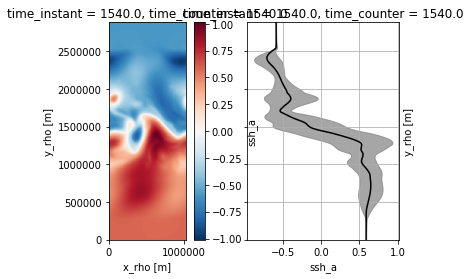

In [120]:
### mean ssh and z-grids

ssh_mean = ds.ssh_a.mean(dim='x_rho')

fig, axs = plt.subplots(1, 2, sharey=True)
ssh_std = ds.ssh_a.std(dim="x_rho")
ds.ssh_a.plot(ax=axs[0])
ssh_mean.plot(ax=axs[1], y="y_rho", color="k")
axs[1].fill_betweenx(r.ds['his'].y_rho, 
                     ssh_mean-ssh_std, 
                     ssh_mean+ssh_std, 
                     color="grey", alpha=.7)

axs[1].grid(True)
axs[1].yaxis.set_label_position("right")
axs[0].set_aspect('equal')

nx = ds.x_rho.size

zmoy = gop.get_z(r, zeta=ssh_mean, h=r.ds['grid'].h.isel(x_rho=nx//2, drop=True), vgrid='r', hgrid='r').persist()
zwoy = gop.get_z(r, zeta=ssh_mean, h=r.ds['grid'].h.isel(x_rho=nx//2, drop=True), vgrid='w', hgrid='r').persist()

Text(0.5, 1.0, 'U_a, x-avg')

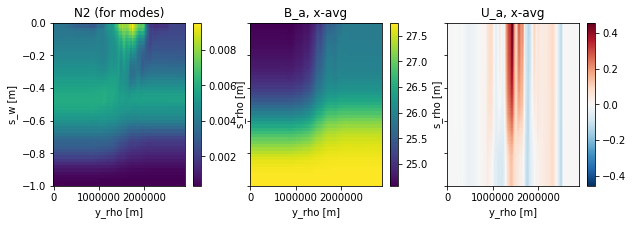

In [121]:
### mean T and N2

z_rho = r.get_z(zeta=ds.ssh_a, vgrid="r", hgrid="r")
Tmoy = bib.z2zmoy(ds.T_a, z_rho, zmoy).mean("x_rho") # interpolate on mean grid
N2 = r.get_N2(Tmoy,zmoy).chunk({"s_w":-1}) # compute stratif
N2 = N2.assign_coords(z_w=zwoy).persist()

### some bricolage in case N2<0
Nmin = 1e-8
prov = N2.values<Nmin
if (N2<=0).any():
    print("wow, I had to fix {0}/{1} negative values in N^2".format(prov.sum(),prov.size))
    N2 = N2.where(N2>Nmin, Nmin)

### plot result    
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10,3))
ax = axs[0]
hpc = np.sqrt(N2).plot(ax=ax)
ax.set_title("N2 (for modes)")
ax = axs[1]
bib.z2zmoy(ds.T_a, z_rho, zmoy).mean("x_rho").plot(ax=ax)
ax.set_title("B_a, x-avg")
ax = axs[2]
bib.z2zmoy(r.xgrid.interp(ds.u_a, "xi", boundary="fill").chunk({"x_rho":-1}), z_rho, zmoy).mean("x_rho").plot(ax=ax)
ax.set_title("U_a, x-avg")

## Compute vertical modes N2(x,y,$\bar{z}$) -> $\phi_{n}$(x,y,$\bar{z}$)

Use Vmodes class (using dask arrays)

<xarray.Dataset>
Dimensions:       (mode: 11, s_rho: 50, s_w: 51, y_rho: 722)
Coordinates:
  * y_rho         (y_rho) float32 -2000.0 2000.0 6000.0 ... 2878000.0 2882000.0
    y_u           (y_rho) float32 -2000.0 2000.0 6000.0 ... 2878000.0 2882000.0
    time_counter  float64 1.54e+03
  * mode          (mode) int64 0 1 2 3 4 5 6 7 8 9 10
  * s_w           (s_w) float32 -1.0 -0.98 -0.96 -0.94 ... -0.06 -0.04 -0.02 0.0
    time_instant  float64 dask.array<chunksize=(), meta=np.ndarray>
    z_w           (s_w, y_rho) float32 dask.array<chunksize=(51, 722), meta=np.ndarray>
  * s_rho         (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.05 -0.03 -0.01
    zc            (s_rho, y_rho) float32 dask.array<chunksize=(50, 722), meta=np.ndarray>
    zf            (s_w, y_rho) float32 dask.array<chunksize=(51, 722), meta=np.ndarray>
Data variables:
    c             (mode, y_rho) float64 dask.array<chunksize=(11, 722), meta=np.ndarray>
    phi           (mode, s_rho, y_rho) float64 dask.array<ch

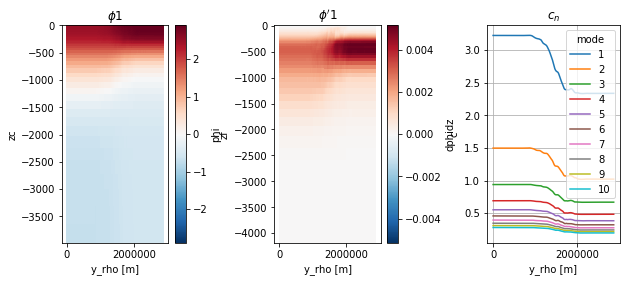

In [133]:
### compute modes
nmodes = 10
#vmodes = vmd.Vmodes(r.xgrid, nmodes, zmoy, zwoy, N2, persist=True)
vmodes = Vmodes(r.xgrid, nmodes, zmoy, zwoy, N2, persist=True) # working version

# plot result (for one mode)
imod = 1
fig, axs = plt.subplots(1, 3, sharex=True, sharey=False, figsize=(10,4))
ax=axs[0]
vmodes.ds.phi.sel(mode=imod).plot(x="y_rho", y="zc", ax=ax)
ax.set_title(r"$\phi $"+str(imod))
ax=axs[1]
vmodes.ds.dphidz.sel(mode=imod).plot(x="y_rho", y="zf", ax=ax)
ax.set_title(r"$\phi' $"+str(imod))
ax = axs[2]
vmodes.ds.c.isel(mode=slice(1,None)).plot.line(x="y_rho", ax=ax)
ax.grid(True)
ax.set_title(r"$c_n$")
fig.subplots_adjust(wspace=.6)

# show result
vmodes.ds

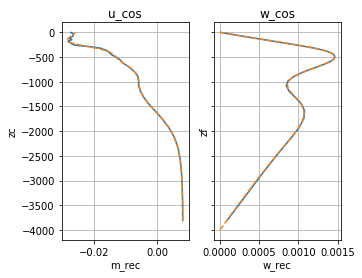

In [134]:
### Application: project fields on base of modes
jy, ix = 350, 0

z_rho = r.get_z(zeta=ds.isel(x_rho=ix).ssh_a, 
                h=r.ds['grid'].h.isel(x_rho=ix), 
                hgrid="r", vgrid="r").drop("y_rho")
z_w = r.get_z(zeta=ds.isel(x_rho=ix).ssh_a, 
              h=r.ds['grid'].h.isel(x_rho=ix), 
              hgrid="r", vgrid="w").drop("y_rho")

uu = r.xgrid.interp(ds.u_t_cos, "xi", boundary="fill").isel(x_rho=nx//2).assign_coords(z_rho=z_rho)
#### in the current version, the projection will broadcast the data on the mode shape -> need align
un = vmodes.proj_puv(uu, align=False, zz=None).isel(y_rho=jy).persist() # need to implement align 

ww = ds.w_t_cos.isel(x_rho=ix).assign_coords(z_rho=z_rho)
wn = vmodes.proj_w(ww).isel(y_rho=jy).persist()

fig, axs = plt.subplots(1, 2, figsize=(5,4), sharey=True)

ax=axs[0]
uu.isel(y_rho=jy).plot(y="z_rho", ax=ax, label="true")
#(un*vmodes.ds.phi.isel(y_rho=jy)).sum("mode").plot(y="zc", ax=ax, label="reco", linestyle="--")
vmodes.reco_puv(un, isel=({"y_rho":jy})).plot(y="zc", ax=ax, label="reco", linestyle="--")
ax.set_title('u_cos')

ax = axs[1]
ww.isel(y_rho=jy).plot(y="z_rho", ax=ax, label="true")
#phiw = -vmodes.ds.c**2/vmodes.ds.N2*vmodes.ds.dphidz
#(wn*phiw).isel(y_rho=jy).sum("mode").plot(y="zf", ax=ax, label="reco", linestyle="--")
vmodes.reco_w(wn, isel={"y_rho":jy}).plot(y="zf", ax=ax, label="reco", linestyle="--")
ax.set_title('w_cos')

for ax in axs:
    ax.grid(True)

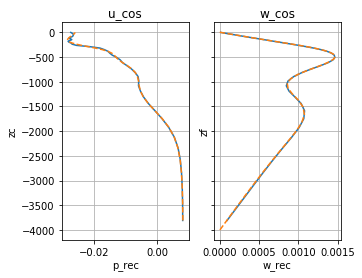

In [129]:
### Application: project fields on base of modes
jy, ix = 350, 0

z_rho = r.get_z(zeta=ds.isel(x_rho=ix).ssh_a, 
                h=r.ds['grid'].h.isel(x_rho=ix), 
                hgrid="r", vgrid="r").drop("y_rho")
z_w = r.get_z(zeta=ds.isel(x_rho=ix).ssh_a, 
              h=r.ds['grid'].h.isel(x_rho=ix), 
              hgrid="r", vgrid="w").drop("y_rho")

uu = r.xgrid.interp(ds.u_t_cos, "xi", boundary="fill").isel(x_rho=nx//2).assign_coords(z_rho=z_rho)
#### in the current version, the projection will broadcast the data on the mode shape -> need align
un = proj_p(vmodes, uu, align=False, zz=None).isel(y_rho=jy).persist() # need to implement align 

ww = ds.w_t_cos.isel(x_rho=ix).assign_coords(z_rho=z_rho)
wn = proj_w(vmodes, ww).isel(y_rho=jy).persist()

fig, axs = plt.subplots(1, 2, figsize=(5,4), sharey=True)

ax=axs[0]
uu.isel(y_rho=jy).plot(y="z_rho", ax=ax, label="true")
#(un*vmodes.ds.phi.isel(y_rho=jy)).sum("mode").plot(y="zc", ax=ax, label="reco", linestyle="--")
reco_puv(vmodes, un, isel=({"y_rho":jy})).plot(y="zc", ax=ax, label="reco", linestyle="--")
ax.set_title('u_cos')

ax = axs[1]
ww.isel(y_rho=jy).plot(y="z_rho", ax=ax, label="true")
#phiw = -vmodes.ds.c**2/vmodes.ds.N2*vmodes.ds.dphidz
#(wn*phiw).isel(y_rho=jy).sum("mode").plot(y="zf", ax=ax, label="reco", linestyle="--")
reco_w(vmodes, wn, isel={"y_rho":jy}).plot(y="zf", ax=ax, label="reco", linestyle="--")
ax.set_title('w_cos')

for ax in axs:
    ax.grid(True)

### Work In Progress
starting from this cell

In [131]:
import scipy.sparse as sp
import scipy.sparse.linalg as la
import numpy as np
import xarray as xr
import crocosi.gridop as gop

g_default = pp.g_default

# default values
_sig = .1
_nmodes = 10

### N.B.: norm is H

# This should be a class
class Vmodes(object):
    """ Description of the class
    """
    def __init__(self, xgrid, nmodes,
                 zc, zf, N2,
                 free_surf=True,
                 persist=False,
                 g=g_default, sigma=_sig):
        """ Create a Vmode object
        
        Parameters
        ----------
            xgrid: xgcm.Grid
                xgcm grid object required for grid manipulations
            ...
            
        """
        self.xgrid = xgrid
        self.nmodes = nmodes
        # create dataset
        self.ds = get_vmodes(zc,
                             zf,
                             N2,
                             nmodes=nmodes,
                             free_surf=free_surf,
                             sigma=sigma)
        self.ds = self.ds.assign_coords(zc=zc.rename('zc'), zf=zf.rename('zf'))
        #self.ds['N2'] = N2.rename('N2').drop("z_w", errors="ignore")
        #self.ds = xr.merge([zc.rename('zc'),
        #                    zf.rename('zf'),
        #                    N2.rename('N2'),
        #                    ])
        # add or derive other useful variables
        # N2 at c points?
        self.ds['H'] = np.abs(self.ds['zf'].sel(s_w=-1,method='nearest'))
        self.ds['dz'] = xgrid.diff(zf, "s").rename("dz")
        if persist:
            self.ds.persist()
        #
        self.g = g
        self.free_surf = free_surf
        self.sigma=_sig
        #self._compute_vmodes(persist)

    def __getitem__(self, item):
        """ Enables calls such as vm['N2']
        """
        return self.ds[item]

    def _compute_vmodes(self, persist):
        # probably here should be instructions contained in compute_vmodes
        # add modes to self.ds, e.g.:
                
        # persist dataset if relevant:
        #if persist:
        #   ...
        pass
    
    ### projection and reconstruction
    
    def project(self, data, vartype="p", zz=None, isel=None, align=False, persist=False, nam=None):
        """ Project a variable on vertical modes, wrapper for the different projection routines
        probably need to use args and kwargs instead of explicit list of kwargs
        """
        if nam is None:
            nam = vartype
        if vartype == "w":
            return self.proj_w(data, zz=zz, isel=isel, align=align, persist=persist, nam=nam)
        elif vartype == "b":
            raise ValueError("b projection not yet implemented")
        else:
            return self.proj_puv(data, zz=zz, isel=isel, align=align, persist=persist, nam=nam)
        pass
    
    def proj_puv(self, data, zz=None, isel=None, align=False, persist=False, nam=None):
        """ projection on p-mode 
        compute int_z(phi_n * field) using sum
        if zz is specified: interpolate data (from zz grid) on mode z-grid before """

        if isel is None:
            dm = self.ds
        else:
            dm = self.ds.isel(isel)
        if align:
            raise ValueError("aligning not implemented")
            # how not to get rid of "modes" when aligning, or align only on existing dimensions?
            #data, dm = xr.align(data, dm, join="left", exclude="mode")
        if zz is not None:
            data = self._z2zmoy(data, zz, align=align)
        res = (dm.dz*data*dm.phi).sum("s_rho")/dm.norm
        if persist:
            res.persist()
        if nam is None:
            nam = data.name[0]
        return res.rename("An_"+nam)
    
    def proj_w(self, data, zz=None, isel=None, align=False, persist=False, nam=None): 
        """ projection on w-modes, varphi = -c*2/N2 * dphidz
        for reconstructing, use w = wn*varphi (see reco_w)
        interpolation uses linear interpolation, but midpoints should be OK 
            (since it gives something equivalent to trapezoidal integration upon integration)
        """
        if isel is None:
            dm = self.ds
        else:
            dm = self.ds.isel(isel)
        if align:
            raise ValueError("aligning not implemented")
            # how not to get rid of "modes" when aligning, or align only on existing dimensions?
            #data, dm = xr.align(data, dm, join="left", exclude="mode")    
        if zz is not None:
            data = self._z2zmoy(data, zz)        
        prov = (data * self._zi_w2rho(-dm.dphidz, align=align) * dm.dz).sum(dim="s_rho")
        if self.free_surf:
            prov += self.g * ( -dm.dphidz / dm.N2 
                              * self.xgrid.interp(data, "s", boundary="extrapolate") 
                             ).isel(s_w=-1).drop("zf")
        prov /= dm.norm
        if persist:
            prov.persist()
        if nam is None:
            nam = "w"
        return prov.rename("An_"+nam)
    
    def reco_puv(self, modamp, isel=None, name=None):
        if isel is None:
            dm = self.ds
        else:
            dm = self.ds.isel(isel)
        if name is None:
            name = modamp.name[-1]
        return (modamp*dm.phi).sum("mode").rename(name+"_rec")

    def reco_w(self, modamp, isel=None):
        if isel is None:
            dm = self.ds
        else:
            dm = self.ds.isel(isel)
        return (-dm.c**2/dm.N2*dm.dphidz * modamp).sum("mode").rename("w_rec")
    
    def _z2zmoy(self, data, zz, align=True):
        """ routine for interpolating data on the mean z-grid used for the modes
        WARNING: I think it works only for initial data on same grid (e.g. dim are "s_rho")"""
        # if not re-chunking, nanny restarts worker
        if "s_rho" in data.dims: 
            data = data.chunk({"s_rho":-1})
        elif "s_w" in data.dims: 
            raise("data should be on s_rho grid, but s_w found") #data = data.chunk({"s_w":-1})
        zc = self.ds.zc
        if align:
            data, zc = xr.align(data, zc, join="inner")
        prov = xr.apply_ufunc(gop.interp2z, zc, zz, data, 2, 2,
                        dask='parallelized', output_dtypes=[np.float64])
        return prov.rename(data.name)
    
    def _zi_w2rho(self, data, zf=None, zc=None, align=True):
        """ routine to interpolate fields from mean rho point to mean w point
        adapt to different ensemble of points if specified
        WARNING: there is a hack: first arg of gridop.zi_w2rho should be a run object, 
        but it works with Vmodes object because only xgrid is needed """
        if zf is None:
            zf = self.ds.zf
        if zc is None:
            zc = self.ds.zc
        return gop.zi_w2rho(self, data, zf, zc)

def z2zmoy(self, data, zz, align=True):
    """ routine for interpolating data on the mean z-grid used for the modes
    WARNING: I think it works only for initial data on same grid (e.g. dim are "s_rho")"""
    # if not re-chunking, nanny restarts worker
    if "s_rho" in data.dims: 
        data = data.chunk({"s_rho":-1})
    elif "s_w" in data.dims: 
        raise("data should be on s_rho grid, but s_w found") #data = data.chunk({"s_w":-1})
    zc = self.ds.zc
    if align:
        data, zc = xr.align(data, zc, join="inner")
    print(data.chunks)
    prov = xr.apply_ufunc(gop.interp2z, zc, zz, data, 2, 2,
                    dask='parallelized', output_dtypes=[np.float64])
    return prov
    
def proj_puv(self, data, zz=None, isel=None, align=False, persist=False, nam=None):
    """ projection on p-mode 
    compute int_z(phi_n * field) using sum
    if zz is specified: interpolate data (from zz grid) on mode z-grid before """

    if isel is None:
        dm = self.ds
    else:
        dm = self.ds.isel(isel)
    if align:
        raise ValueError("aligning not implemented")
        # how not to get rid of "modes" when aligning, or align only on existing dimensions?
        #data, dm = xr.align(data, dm, join="left", exclude="mode")
    if zz is not None:
        data = self._z2zmoy(data, zz, align=align)
    res = (dm.dz*data*dm.phi).sum("s_rho")/dm.norm
    if persist:
        res.persist()
    if nam is None:
        nam = data.name[0]
    return res.rename("An_"+nam)

def proj_w(self, data, zz=None, isel=None, align=False, persist=False): 
    """ using what I call "w-modes".
    for reconstructing, use w = wn*modw 
    interpolation uses linear interpolation, but midpoints should be OK 
        (since it gives something equivalent to trapezoidal integration upon integration)
    """
    # this should be similar to -N2/c**2*dphidz
    #phiw = grid.cumsum(dz*dm.phi, "s", to="outer", boundary="fill")\
    #        .chunk({"s_w":-1})
    if isel is None:
        dm = self.ds
    else:
        dm = self.ds.isel(isel)
    if align:
        raise ValueError("aligning not implemented")
        # how not to get rid of "modes" when aligning, or align only on existing dimensions?
        #data, dm = xr.align(data, dm, join="left", exclude="mode")    
    if zz is not None:
        data = self._z2zmoy(data, zz)        
    prov = (data*self._zi_w2rho(-dm.dphidz, align=align)*dm.dz).sum(dim="s_rho")
    if self.free_surf:
        prov += self.g * (-dm.dphidz/dm.N2*self.xgrid.interp(data, "s", boundary="extrapolate")).isel(s_w=-1).drop("zf")
    prov /= dm.norm
    if persist:
        prov.persist()
    return prov.rename("An_w")

def reco_w(self, modamp, isel=None):
    if isel is None:
        dm = self.ds
    else:
        dm = self.ds.isel(isel)
    return (-dm.c**2/dm.N2*dm.dphidz * modamp).sum("mode").rename("w_rec")
    
def reco_puv(self, modamp, isel=None, name=None):
    if isel is None:
        dm = self.ds
    else:
        dm = self.ds.isel(isel)
    if name is None:
        name = modamp.name[-1]
    return (modamp*dm.phi).sum("mode").rename(name+"_rec")

def get_vmodes(zc, zf, N2, nmodes=_nmodes, **kwargs):
    """ wrapper for calling compute_vmodes with apply_ufunc. Includes unstacking of result
    this is what you should need in your scripts, unless you are using numpy arrays only 
    input:
        - zc: z-levels at center of cells
        - zf: z-levels at cell faces
        - N2: BVF at cell faces 
        - nmodes (default:10): number of vertical modes (+ barotropic)
    z levels must be in ascending order (first element is at bottom, last element is at surface)
    output: xarray dataset with phase speed, pressure-modes (at center) and b-modes (at faces)
    kwargs:
        - free_surf (bool): use free surface boundary condition (default:True)
        - sigma (scalar or None): for shift-invert in eig (default: 0.1)
    """
    kworg = {"nmodes":nmodes, "stacked":True}
    if kwargs is not None:
        kworg.update(kwargs)
    N = zc.s_rho.size
    res = xr.apply_ufunc(compute_vmodes, 
                         zc.chunk({"s_rho":-1}), 
                         zf.chunk({"s_w":-1}),
                         N2.chunk({"s_w":-1}), 
                         kwargs=kworg, 
                         input_core_dims=[["s_rho"],["s_w"],["s_w"]],
                         dask='parallelized', 
                         output_dtypes=[np.float64],
                         output_core_dims=[["s_stack","mode"]],
                         output_sizes={"mode":nmodes+1,"s_stack":2*(N+1)}
                        )
    res['mode'] = np.arange(nmodes+1)
    # unstack variables
    c = res.isel(s_stack=0).rename('c')
    phi = (res.isel(s_stack=slice(1,N+1))
           .rename('phi')
           .rename({'s_stack': 's_rho'})
           #.assign_coords(z_rho=zc)
          )
    dphidz = (res.isel(s_stack=slice(N+1,2*N+2))
              .rename('dphidz')
              .rename({'s_stack': 's_w'})
            #  .assign_coords(z_w=zf)
             )
    # merge data into a single dataset
    other_dims = tuple([dim for dim in zc.dims if dim!="s_rho"]) # extra dims    
    dm = (xr.merge([c, phi, dphidz, -zf.isel(s_w=0, drop=True).rename('norm'), N2.rename('N2')])
          .transpose(*('mode','s_rho','s_w')+other_dims)
          #.assign_coords(norm=-zf.isel(s_w=0, drop=True)) #, N2=N2
         )
    return dm  ### hard-coded norm = H

def compute_vmodes(zc_nd, zf_nd, N2f_nd, 
                   nmodes=_nmodes, free_surf=True,
                   g=g_default,
                   sigma=_sig, stacked=True,
                   **kwargs):
    """
    wrapper for vectorizing compute_vmodes_1D over elements of axes other than vertical dim
    that's not elegant, nor efficient
    here z is last axis (because it is core dim)
    you can use this if you are using numpy (but make sure z is last dim)
    """
    assert zc_nd.ndim==zf_nd.ndim==N2f_nd.ndim
    assert zf_nd.shape==N2f_nd.shape
    if "nmodes" in kwargs:
        nmodes = kwarg["nmodes"]
    if "free_surf" in kwargs:
        free_surf = kwargs["free_surf"]
        if "stacked" in kwargs:
            stacked = kwargs["stacked"]

    if zc_nd.ndim>1:
        nxy = zc_nd.shape[:-1]
        nn = np.prod(nxy)
        zc_nd = zc_nd.reshape(nn,zc_nd.shape[-1])
        zf_nd = zf_nd.reshape(nn,zf_nd.shape[-1])
        N2f_nd = N2f_nd.reshape(nn,N2f_nd.shape[-1])
        ii = 0
        cn, phin, dphi = compute_vmodes_1D(zc_nd[ii,:], zf_nd[ii,:], N2f_nd[ii,:], nmodes, \
                                free_surf=free_surf, g=g, sigma=sigma)
        cn, phin, dphi = cn[None,:], phin[None,...], dphi[None,...]
        for ii in range(1,nn):
            res = compute_vmodes_1D(zc_nd[ii,:], zf_nd[ii,:], N2f_nd[ii,:], nmodes, \
                                free_surf=free_surf, g=g, sigma=sigma)
            cn = np.vstack([cn, res[0][None,...]])
            phin = np.vstack([phin,res[1][None,...]])
            dphi = np.vstack([dphi,res[2][None,...]])
        if stacked:
            return np.hstack([cn[:,None,:],phin,dphi]).reshape(nxy+(-1,nmodes+1))
        else:
            return cn.reshape(nxy+(nmodes,)), phin.reshape(nxy+(-1,nmodes)), \
                        dphi.reshape(nxy+(-1,nmodes))
    else:
        return compute_vmodes_1D(zc_nd, zf_nd, N2f_nd, nmodes, \
                                free_surf=free_surf, g=g, sigma=sigma)

            
def compute_vmodes_1D(zc, zf, N2f, 
                      nmodes=_nmodes, free_surf=True, 
                      g=g_default, sigma=_sig):
    """ compute vertical modes: solution of SL problem (phi'/N^2)'+k*phi=0'
    returns phi at rho points, dphi at w points and c=1/sqrt(k) 
    normalization such that int(phi^2)=H, w-modes=d(phi)/dz
    copy-pasted from M. Dunphy's vmodes_MD.py
    TODO: correct rigid lid & barotropic mode """
    # Precompute a few quantities
    assert zc.ndim==zf.ndim==N2f.ndim==1
    assert len(zc)+1==len(N2f)==len(zf)
    dzc=np.diff(zc)
    dzf=np.diff(zf)
    Np=len(zf) #self.zf)
    N20=N2f[-1] #self.N2f[-1]  # N^2(z=0)
    H = abs(zf[0])
    
    # Build Dz, C-to-F grid 
    v1=-1.0/np.concatenate([dzc,np.ones(1)])
    v2= 1.0/np.concatenate([np.ones(1),dzc])
    v12=np.stack([v1, v2])
    Dz=sp.spdiags(v12,[-1, 0],Np,Np-1,format="lil")
    # Adjust matrix for BCs
    Dz[0,:]=0
    Dz[-1,:]=0
    if free_surf:
        Dz[-1,-1]=np.divide(-N20, g + N20*(zf[-1] - zc[-1]))

    # Build Dz2, F-to-C grid
    v1=-1.0/np.concatenate([dzf,np.ones(1)])
    v2= 1.0/np.concatenate([np.ones(1),dzf])
    v12=np.stack([v1,v2])
    Dz2=sp.spdiags(v12,[0, 1],Np-1,Np,format="lil")
    
    # Construct A, solve eigenvalue problem
    iN2=sp.spdiags(1.0/N2f,0,Np,Np)
    A=-Dz2*iN2*Dz
    ev,ef = la.eigs(A.tocsc(),nmodes+1,sigma=sigma)
    ev,ef = np.real(ev), np.real(ef)
    
    # Convert eigvenvalues to c_e, sort appropriately
    c=1.0/np.sqrt(np.real(ev))
    ii=(-c).argsort()
    c=c[ii]               # c_e value
    phic=ef[:,ii]         # phi at cell centres

    # Normalize and set surface value positive
    for mi in range(nmodes+1):
        fn=phic[:,mi]        # current phi
        s=np.sign(fn[-1])         # sign at surface
        if s==0:
            s=1;
        tmp = np.sum((fn**2)*dzf)/H
        phic[:,mi] = s*fn/np.sqrt(tmp) # (1/H)*\int_{-H}^{0} \phi_m(z)^2 dz = 1
        
    # dphi at cell faces: phi'=dphidz (buoyancy modes)
    dphif = Dz*phic
    # this would give w-modes: np.r_[np.zeros((1,nmodes+1)),(dzf[:,None]*phic).cumsum(axis=0)]
    return c, phic, dphif


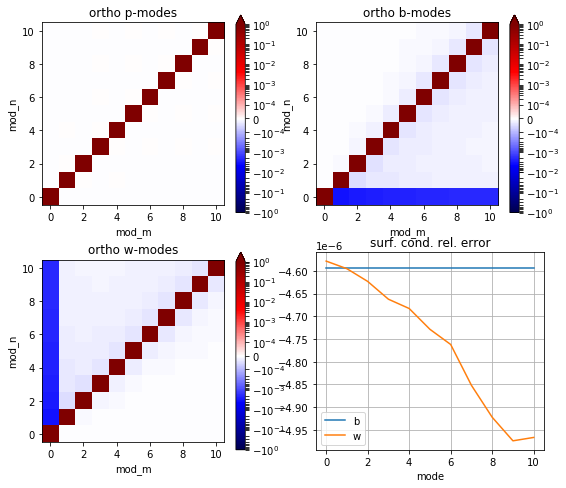

In [13]:
### check orthogonality and free surf condition -- buoy modes
# the small error in w is probably due to mismatch at the surf of integrated phi
fig, axs = plt.subplots(2, 2, figsize=(9,8))
axs = axs.ravel()

h_mean = r["grid"].h.mean()

grid = r['xgrid']
sds = ds.isel(x_rho=0, y_rho=0).persist()
modn = sds.phi.rename({'mode':'mod_n'})
modm = sds.phi.rename({'mode':'mod_m'})
orthomat = (grid.diff(sds.z_w, "s")*modn*modm).sum("s_rho")/h_mean
orthomat.plot.imshow(norm=mpl.colors.SymLogNorm(linthresh=1e-4,vmin=-1,vmax=1), cmap="seismic", ax=axs[0])
axs[0].set_title('ortho p-modes')

grav = 9.81
# buoyancy modes, = d phi / dz
mobn = sds.dphidz.rename({'mode':'mod_n'})
mobm = sds.dphidz.rename({'mode':'mod_m'})
orthobat = (mobn*mobm/N2.isel(y_rho=0,x_rho=0)).integrate(dim="z_w") \
            + grav* mobn.isel(s_w=-1)*mobm.isel(s_w=-1)/N2.isel(y_rho=0,x_rho=0,s_w=-1)**2 
            #+ modn.isel(s_rho=-1)*modm.isel(s_rho=-1)/grav
orthobat *= sds.c.rename({'mode':'mod_n'})**2/h_mean
orthobat.plot.imshow(norm=mpl.colors.SymLogNorm(linthresh=1e-4,vmin=-1,vmax=1), cmap="seismic", ax=axs[1])
axs[1].set_title('ortho b-modes')

# w modes, = int(phi)
mown = grid.cumsum(grid.diff(sds.z_w, "s")*sds.phi, "s", to="outer", boundary="fill")
mown = mown.assign_coords(z_w=sds.z_w).rename({"mode":"mod_n"})
mowm = mown.rename({"mod_n":"mod_m"})
orthowat = (mown*mowm*N2.isel(y_rho=0,x_rho=0)).integrate(dim="z_w") \
            + grav* mown.isel(s_w=-1)*mowm.isel(s_w=-1)
orthowat /= sds.c.rename({'mode':'mod_n'})**2*h_mean
orthowat.plot.imshow(norm=mpl.colors.SymLogNorm(linthresh=1e-4,vmin=-1,vmax=1), cmap="seismic", ax=axs[2])
axs[2].set_title('ortho w-modes')

# check free surface condition : w(0) = c²/g p(0)
ax = axs[3]
relerb = 1 + N2.isel(x_rho=0,y_rho=0,s_w=-1)*sds.phi.isel(s_rho=-1)/grav/sds.dphidz.isel(s_w=-1)
relerb.plot(ax=ax, label="b")
relerw = 1 - sds.phi.isel(s_rho=-1)*sds.c**2/grav/mown.isel(s_w=-1).rename({'mod_n':'mode'})
relerw.plot(ax=ax, label='w')
ax.set_title('surf. cond. rel. error')
ax.grid(True)
ax.ticklabel_format(style='sci',scilimits=(-2,3))
ax.legend()

for ax in axs[:3]:
    ax.set_aspect('equal')
    
fig.subplots_adjust(wspace=.2)

# Projection of a variable on vertical modes

**Interpolation of the variable on zmean -> var(x,y,$\bar{z}$,t)**

this is still ongoing work

In [14]:
# define get_p (not sure this is correct)
# it would be nice to be able to interpolate from w-grid to r-grid (e.g. get rid of broadcasting)
# I think p is wrong for now

def get_p_zmoy(ds, zr, zw, rho, zrho=None):
    _g = 9.81
    grid = ds.attrs['xgrid']
    if zrho is not None:
        rho = xr.apply_ufunc(interp2z, zr, zrho, rho, False, \
                    dask='parallelized', output_dtypes=[np.float64])
    pres =  grid.cumsum(grid.diff(zw, "s")*rho*_g, "s", to="outer", boundary="fill") 
    pres = pres - pres.isel(s_w=-1) # how to get cumsum going the other way ?
    return grid.interp(pres, "s")

def get_p(r, ds, rho, zeta, z=None):
    """ this is the baroclinic pressure, without rho0*zeta and int(rho0) """
    # this is a bit wrong, because variable boundary for integration of rho makes pressure nonlinear
    
    _g = 9.81
    zw = get_z(r, zeta, h=ds.h, vgrid='w', hgrid='r')
    grid = ds.attrs['xgrid']
    pres =  grid.cumsum(grid.diff(zw, "s")*rho*_g, "s", to="outer", boundary="fill") 
    if z is None:
        return grid.interp(pres, "s")
    else:
        return xr.apply_ufunc(interp2z, z, zw.chunk({'s_w':-1}), pres.chunk({'s_w':-1}), False, \
                    input_core_dims=[['s_rho'],['s_w'],['s_w'],[]], output_core_dims=[['s_rho']], \
                    dask='parallelized', output_dtypes=[np.float64])


In [15]:
# project p, u and v
### not using interpolated field because can't extrapolate, hence nan                                        

ds = r['his']
grid = ds.attrs['xgrid']
dz = grid.diff(zf, "s")
hwean = np.abs(zwean.isel(s_w=-1)-zwean.isel(s_w=0))

### first pressure
#pp = get_p(r, ds, ds.T_t_cos, ds.ssh_t_cos)
pp = get_p_zmoy(ds, zmean, zwean, ds.T_t_cos, z)
pn = (dz*pp*phin).sum("s_rho")/hwean

### then x-velocity
ur = grid.interp(ds.u_t_cos, "xi").rename({'y_u':'y_rho'}) # question: does grid.interp know how to broadcast?
#ur = xr.apply_ufunc(interp2z, zmean, z, ur, True, 
#                    dask='parallelized', output_dtypes=[np.float64])
un = (dz*ur*phin).sum("s_rho")/hwean

### then y-velocity
vv = r['his'].v_t_cos
vr = grid.interp(vv, "eta").rename({'x_v':'x_rho'})
vn = (dz*vr*phin).sum("s_rho")/hwean


NameError: name 'zf' is not defined

In [17]:
ds.T_t_cos.isel(time=0,x_rho=jj).plot()

NameError: name 'jj' is not defined

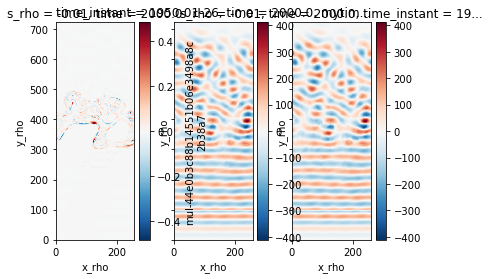

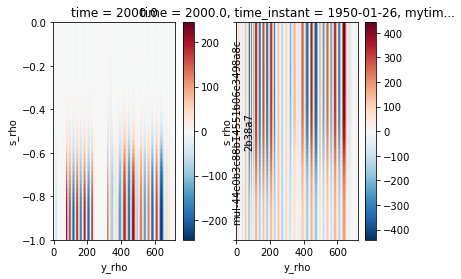

In [72]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)

psurf = pp.isel(s_rho=-1).isel(time=0)
etap = (ds.ssh_t_cos*(r.params['rho0']+T.isel(s_rho=-1))*9.81).isel(time=0)

psurf.plot(ax=axs[0])
etap.plot(ax=axs[1])
(psurf+etap).plot(ax=axs[2])

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
psec = pp.isel(x_rho=jj).isel(time=0)
ptot = psec + etap.isel(x_rho=jj)
psec.plot(ax=axs[0])
pbcl.plot(ax=axs[1])

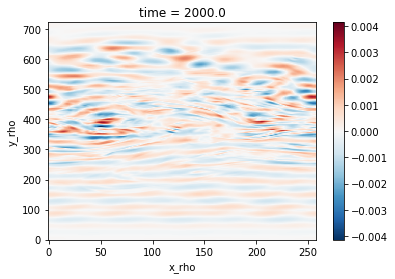

In [127]:
un.isel(time=0,modes=0).plot(x="x_rho")

In [17]:
### u2rho returns " KeyError: 'X' "
uu = r['his'].u_t_cos.isel(x_u=[jj,jj+1]).mean("x_u")

ui = xr.apply_ufunc(interp2z, zmean, z, uu, False, 
                    dask='parallelized', output_dtypes=[np.float64])

### I need to switch dim from "s_w" to "s_rho" for dz
### same for u, v -> need u2rho, v2rho and have xarray understand y_u = y_rho
un = (zwean.diff('s_w')*ui*phin).sum("s_rho")

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 16.3 ms
